### 1. Import libraries

In [1]:
from ezyrb import POD, AE, GPR, RBF, Database
from ezyrb import ReducedOrderModel as ROM
import torch

from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
np.bool = np.bool_ # to avoid error in pyvista

import matplotlib.pyplot as plt

from varname import nameof
import pyvista as pv

### 2. Read and preprocess of the data

In [2]:
# Assuming your data preparation steps are done here
num_simulations = 200
train_ratio = 0.8

# Load npy data from training_data folder
pressure_data = np.load('training_data/pressure_data_concat.npy')
velocity_data = np.load('training_data/velocity_data_concat.npy')
points_data = np.load('training_data/points_data.npy')

# Load design parameters from training_data folder
design_parameters = np.load('training_data/displacement_data_concat.npy')

In [3]:
random_state = 42

# randomly spit the data into training and testing data
train_pressure, test_pressure = train_test_split(pressure_data, train_size=train_ratio, random_state=random_state)
train_velocity, test_velocity = train_test_split(velocity_data, train_size=train_ratio, random_state=random_state)
train_design_parameters, test_design_parameters = train_test_split(design_parameters, train_size=train_ratio, random_state=random_state)
train_points, test_points = train_test_split(points_data, train_size=train_ratio, random_state=random_state)

In [4]:
# delete columns with all zeros in train_design_parameters
eliminate_columns = np.all(train_design_parameters == 0, axis=0)
train_design_parameters = train_design_parameters[:, ~eliminate_columns]
test_design_parameters = test_design_parameters[:, ~eliminate_columns]

### 3. AE evaluation

In [5]:
def PODI_rom(ae, model, train_design_parameters, train_data):
    # Define the database
    db = Database(train_design_parameters, train_data)
    # Define the ROM
    rom = ROM(db, ae, model)
    rom.fit()

    return rom

### 4. RBF interpolation

[epoch      1]	1.013153e+00
[epoch     50]	1.469329e-01
[epoch    100]	6.140608e-02
[epoch    150]	3.457034e-02
[epoch    200]	2.566472e-02
[epoch    250]	1.939832e-02
[epoch    300]	1.553593e-02
[epoch    350]	1.261326e-02
[epoch    400]	1.061640e-02
[epoch    450]	8.423417e-03
[epoch    500]	7.234616e-03
[epoch    550]	6.597759e-03
[epoch    600]	5.633428e-03
[epoch    650]	5.125875e-03
[epoch    700]	4.428545e-03
[epoch    750]	4.096215e-03
[epoch    800]	3.823570e-03
[epoch    850]	3.573191e-03
[epoch    900]	3.304866e-03
[epoch    950]	3.171556e-03
[epoch   1000]	2.746033e-03
[epoch   1050]	2.535891e-03
[epoch   1100]	2.347462e-03
[epoch   1150]	2.227718e-03
[epoch   1200]	2.382804e-03
[epoch   1250]	2.190430e-03
[epoch   1300]	1.830745e-03
[epoch   1350]	1.828129e-03
[epoch   1400]	1.589790e-03
[epoch   1450]	1.514240e-03
[epoch   1500]	1.535909e-03
[epoch   1550]	1.482390e-03
[epoch   1600]	1.311702e-03
[epoch   1650]	1.244448e-03
[epoch   1700]	1.222532e-03
[epoch   1750]	1.159

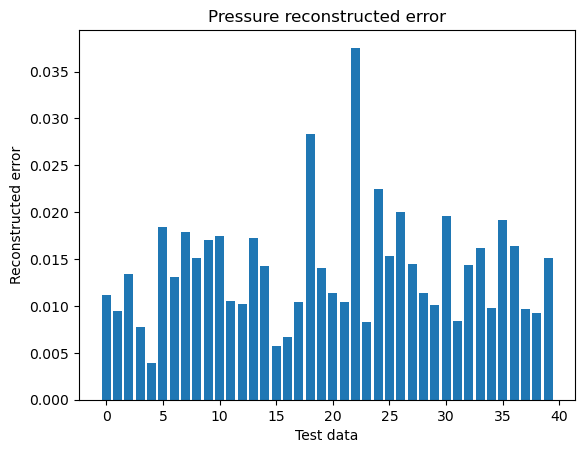

In [20]:
# Normalize the training data
scaler = StandardScaler()
train_pressure_scaled = scaler.fit_transform(train_pressure)
test_pressure_scaled = scaler.transform(test_pressure)

# Evaluate AE on the pressure data
low_dim = 20
optim = torch.optim.Adam
encoder_list = [200, low_dim]
decoder_list = [low_dim, 200]
encoder_activation = torch.nn.Tanh
decoder_activation = torch.nn.Tanh

p_ae = AE(encoder_list, decoder_list, encoder_activation(), decoder_activation(), 
          [3000, 1e-5], optimizer=optim, frequency_print=50)

# Define the GPR model
p_gpr = GPR()

# Perform PODI on the pressure data
p_rom = PODI_rom(p_ae, p_gpr, train_design_parameters, train_pressure_scaled)

# Predict the pressure data
p_predict = p_rom.predict(test_design_parameters)
p_predict_data = scaler.inverse_transform(p_predict.snapshots_matrix)

# calculate the reconstrcuted error for each test data using mean squared error
p_reconstructed_error = np.linalg.norm(test_pressure - p_predict_data, axis=1) / np.linalg.norm(test_pressure, axis=1)

# plot the error
plt.bar([i for i in range(len(p_reconstructed_error))], p_reconstructed_error)
plt.title('Pressure reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

In [24]:
# Evaluate AE on the pressure data
low_dim = 50
optim = torch.optim.Adam
encoder_list = [2000, 100, low_dim]
decoder_list = [low_dim, 1000, 2000]
encoder_activation = torch.nn.Tanh
decoder_activation = torch.nn.Tanh

u_ae = AE(encoder_list, decoder_list, encoder_activation(), decoder_activation(), 
          [1000, 1e-5], optimizer=optim, frequency_print=20)

# Define the GPR model
u_gpr = GPR()

# Perform PODI on the pressure data
u_rom = PODI_rom(u_ae, u_gpr, train_design_parameters, train_velocity)

# Predict the pressure data
u_predict = u_rom.predict(test_design_parameters)

# calculate the reconstrcuted error for each test data using mean squared error
u_reconstructed_error = np.linalg.norm(test_velocity - u_predict.snapshots_matrix, axis=1) / np.linalg.norm(test_velocity, axis=1)

# plot the error
plt.bar([i for i in range(len(u_reconstructed_error))], u_reconstructed_error)
plt.title('Velocity reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

[epoch      1]	1.844543e-01
[epoch     20]	5.797183e-03
[epoch     40]	1.995192e-03
[epoch     60]	1.475034e-03
[epoch     80]	1.406138e-03


### 5. VTK visualization

In [ ]:
# Define a funtion to write the data into a VTK file
def vtk_writer(field_data, field_name, data_type,
               refVTM, save_path_name, points_data = None):
    # Add velocity data to each block within the MultiBlock dataset
    
    for block_i in range(refVTM.n_blocks):
        block = refVTM[block_i]
        if block is not None:
            if data_type == 'scalar':
                for data_i in range(len(field_name)):
                    block.cell_data[field_name[data_i]] = field_data[data_i]
            elif data_type == 'vector':
                for data_i in range(len(field_name)):
                    field = field_data[data_i].reshape(3, -1).T
                    block.cell_data[field_name[data_i]] = field 
            if points_data is not None:
                points = points_data.reshape(3, -1).T
                block.points = points

    # Save the modified VTM file
    output_vtm_file_path = f'{save_path_name}.vtm'
    refVTM.save(output_vtm_file_path)

In [18]:
# write the truth data, reconstructed data, and error into a VTK file
# Load the reference mesh VTM file
refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')
field_name = ['truth', 'reconstructed', 'error']
p_error_field = test_pressure - p_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_pressure)):
    vtk_writer([test_pressure[i], p_predict.snapshots_matrix[i], p_error_field[i]], 
                field_name, 'scalar', refVTM, f'visualization_data/EZyRB_PODI_GPR/test_case_{i}_pressure', test_points[i])

In [19]:
# Write the velocity data into VTK file
field_name = ['truth', 'reconstructed', 'error']
u_error_field = test_velocity - u_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_velocity)):
    vtk_writer([test_velocity[i], u_predict.snapshots_matrix[i], u_error_field[i]], 
                field_name, 'vector', refVTM, f'visualization_data/EZyRB_PODI_GPR/test_case_{i}_velocity', test_points[i])